## LSH Density Estimation Performance Assessment

Assessing the performance of the LSH density estimation algorithm

In [1]:
from performance_assessment.benchmark_gmm import sample_blobs
from lsh_density.lsh_based_kde import run_high_dim_kde
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random as rd

#### Explorqtion of sklearn's `sklearn.datasets.make_blobs`

Given the objective is to assess the performance of the LSH density estimation algorithm, we will use `sklearn.datasets.make_blobs` to generate synthetic data. This function allows us to create a dataset with a specified number of samples, centers, and cluster standard deviation.

By creating a dataset with multiple clusters, we will be able to set a ground truth for the density estimation. If we count the number of points in each cluster, we can compare the estimated density against this ground truth.

In [2]:
samples, labels = sample_blobs(n_samples=1000, n_features=2, clusters_centers=1, cluster_std=1, random_state=42, verbose=True)
print()
print("Samples shape:", samples.shape)
print("Set of labels:", set(labels))

Generating 1000 samples with 2 features each, 1 cluster centers, and standard deviation 1.
Generated 1000 samples with 2 features each.

Samples shape: (1000, 2)
Set of labels: {0}


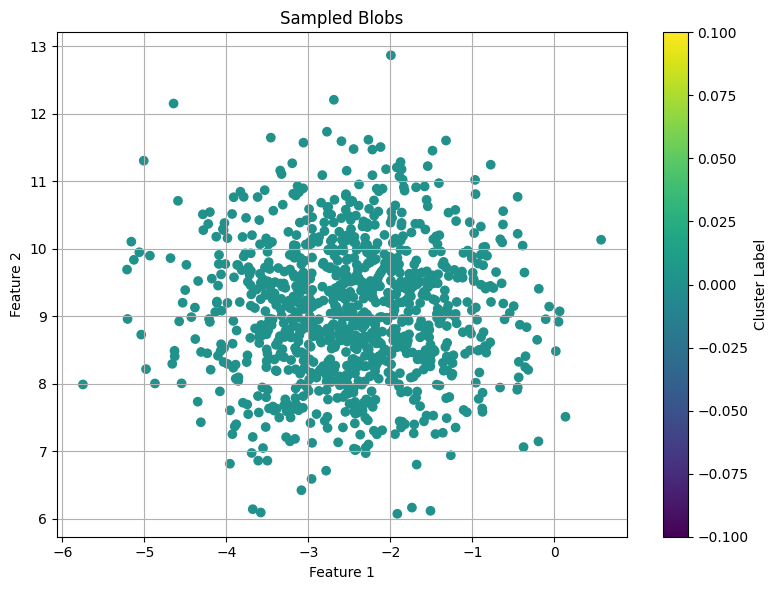

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], c=labels, cmap='viridis')
plt.title('Sampled Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.tight_layout()
plt.show()

In [4]:
samples, labels = sample_blobs(n_samples=1000, n_features=2, clusters_centers=3, cluster_std=1, random_state=42, verbose=True)
print()
print("Samples shape:", samples.shape)
print("Set of labels:", set(labels))

Generating 1000 samples with 2 features each, 3 cluster centers, and standard deviation 1.
Generated 1000 samples with 2 features each.

Samples shape: (1000, 2)
Set of labels: {0, 1, 2}


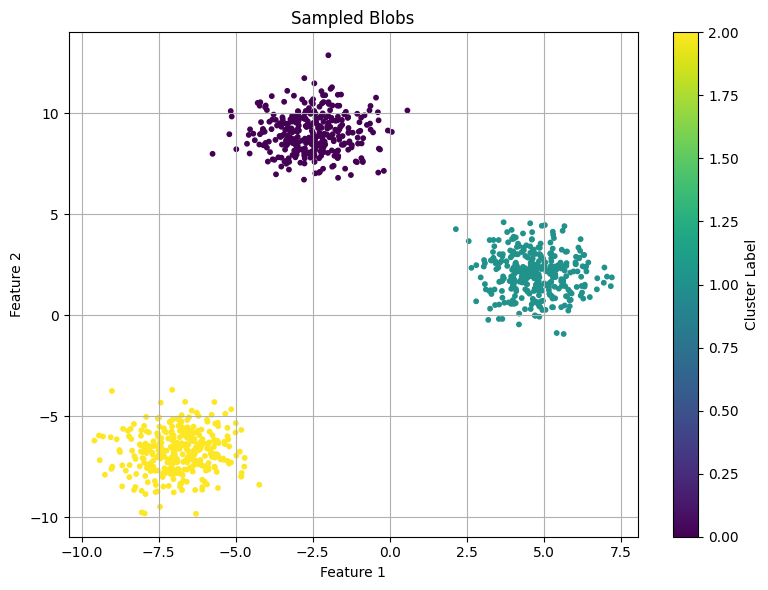

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], c=labels, cmap='viridis', s=10)
plt.title('Sampled Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.tight_layout()
plt.show()

#### LSH Density Estimation on 3D Data

We will generate a 3D dataset using `sample_blobs` and then apply the LSH density estimation algorithm. The performance will be assessed by comparing the estimated density against the ground truth.

<ins>Reminder:</ins> The LSH density estimation algorithm is designed to work with high-dimensional data (at least 3D, 2D leading to hashing the data in only 2 buckets). Therefore, we will first try on a 3D dataset.

Additionally, given the `sample_blobs` function generates clusters of equal size, we will need to create a more complex dataset, to plot a histogram that does not only show a single peak.

In [6]:
all_samples = []
all_labels = []
for _ in range(15):
    n_samples = rd.randint(10, 1000)
    std = rd.uniform(0.1, 1.0)
    clusters_centers = rd.randint(1, 10)
    samples, labels = sample_blobs(n_samples=n_samples, n_features=3, clusters_centers=clusters_centers, cluster_std=std, random_state=42, verbose=False)
    all_samples += samples.tolist()
    all_labels += labels
    
all_samples = np.array(all_samples)
print()
print("All samples shape:", all_samples.shape)
print("Set of labels:", set(all_labels))


All samples shape: (9810, 3)
Set of labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


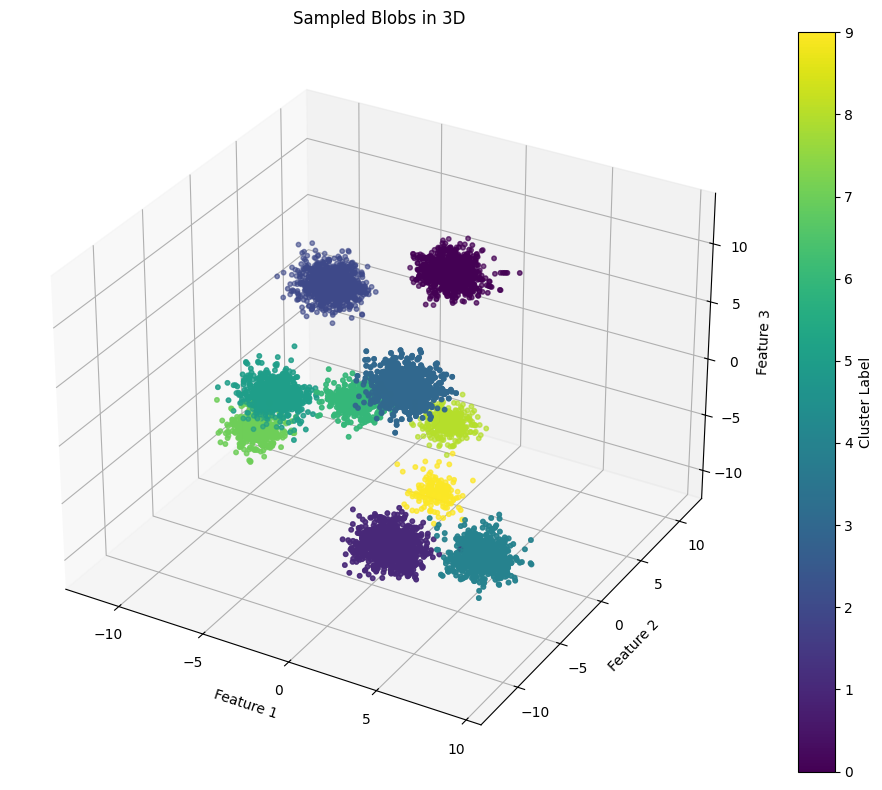

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(all_samples[:, 0], all_samples[:, 1], all_samples[:, 2], c=all_labels, cmap='viridis', s=10)
ax.set_title('Sampled Blobs in 3D')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.colorbar(ax.scatter(all_samples[:, 0], all_samples[:, 1], all_samples[:, 2], c=all_labels, cmap='viridis', s=10), label='Cluster Label')
plt.grid()
plt.tight_layout()
plt.show()

In [8]:
unique_labels, counts = np.unique(labels, return_counts=True)
unique_labels = unique_labels.tolist()
counts = counts.tolist()

count_dict = {
    label: count for label, count in zip(unique_labels, counts)
}

neighbor_counts = []
for index, label in enumerate(labels):
    neighbor_counts.append(count_dict[label] - 1)  # Exclude the sample itself
    
relative_densities = [count / len(neighbor_counts) for count in neighbor_counts]

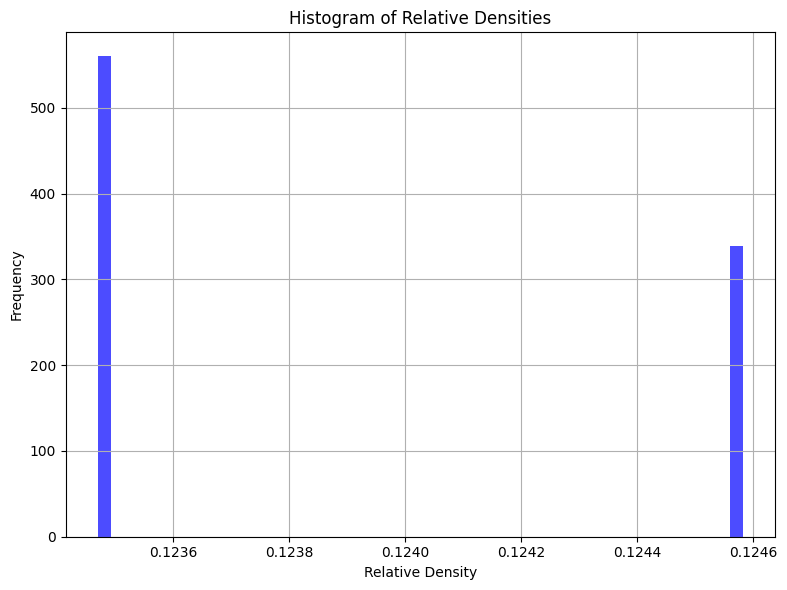

In [9]:
# Plotting the histogram of relative densities
plt.figure(figsize=(8, 6))
plt.hist(relative_densities, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Relative Densities')
plt.xlabel('Relative Density')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.show()

**The "per-cluster" count technique for dataset estimation is too weak to obtain a solid ground truth - need to find another method/workaround**

In [10]:
lsh_densities = run_high_dim_kde(dataset=all_samples, hash_bits_per_table=16, number_of_hash_tables=30, random_state=42, verbose=True)

Running LSH-based KDE with 16 hash bits per table and 30 hash tables.
Preparing hash tables and planes...
Hash tables and planes prepared.
Hashing the dataset...
Dataset hashed.
Computing densities for the dataset...
Densities computed.
Computed densities using LSH and SimHash for 9810 samples.


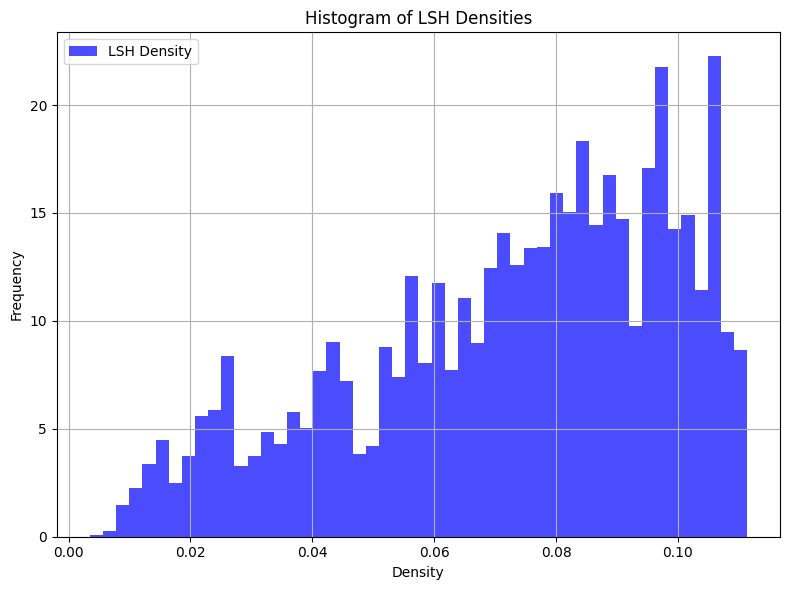

In [13]:
# Plotting the histogram of relative densities and the kde
plt.figure(figsize=(8, 6))
plt.hist(lsh_densities, bins=50, color='blue', alpha=0.7, label='LSH Density', density=True)
plt.title('Histogram of LSH Densities')
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()